In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.api.models import Sequential
from keras.api.layers import Dense
from keras.api.layers import LSTM
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [7]:
tf.random.set_seed(123)

df_precios = pd.read_csv('precios.csv', encoding='latin1')

df_precios.head()

,MES/ANO,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,ENERO,8.95,10.46,12.19,15.68,19.59,18.68,26.02,19.11,24.13,...,18.86,13.65,18.35,20.74,19.87,21.09,18.02,26.40,35.79,29.16
1,FEBRERO,8.66,11.50,11.90,15.10,19.16,17.64,26.09,17.97,23.59,...,19.81,13.02,17.89,20.39,21.09,18.74,19.46,29.29,33.02,30.72
2,MARZO,8.69,12.83,12.17,16.01,18.51,18.80,27.84,16.73,23.96,...,20.18,14.80,17.60,20.07,21.86,17.11,21.21,36.21,30.67,29.97
3,ABRIL,9.38,12.22,13.71,17.89,19.35,20.34,30.47,16.60,24.56,...,20.04,15.12,17.60,21.22,21.94,14.91,20.65,32.95,29.78,29.78
4,MAYO,9.44,10.63,13.79,18.31,20.38,20.91,32.31,17.33,24.42,...,21.32,16.26,16.86,22.29,21.97,14.09,21.75,34.83,27.43,28.17


In [8]:
print(df_precios['MES/ANO'].unique())

['ENERO' 'FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO' 'AGOSTO'
 'SEPTIEMBRE' 'OCTUBRE' 'NOVIEMBRE' 'DICIEMBRE' 'Promedio']


In [9]:
meses_dict = {
    'ENERO': 'Jan',
    'FEBRERO': 'Feb',
    'MARZO': 'Mar',
    'ABRIL': 'Apr',
    'MAYO': 'May',
    'JUNIO': 'Jun',
    'JULIO': 'Jul',
    'AGOSTO': 'Aug',
    'SEPTIEMBRE': 'Sep',
    'OCTUBRE': 'Oct',
    'NOVIEMBRE': 'Nov',
    'DICIEMBRE': 'Dec'
}

df_precios['MES/ANO'] = df_precios['MES/ANO'].map(meses_dict)
df_precios

,MES/ANO,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Jan,8.95,10.46,12.19,15.68,19.59,18.68,26.02,19.11,24.13,...,18.86,13.65,18.35,20.74,19.87,21.09,18.02,26.40,35.79,29.16
1,Feb,8.66,11.50,11.90,15.10,19.16,17.64,26.09,17.97,23.59,...,19.81,13.02,17.89,20.39,21.09,18.74,19.46,29.29,33.02,30.72
2,Mar,8.69,12.83,12.17,16.01,18.51,18.80,27.84,16.73,23.96,...,20.18,14.80,17.60,20.07,21.86,17.11,21.21,36.21,30.67,29.97
3,Apr,9.38,12.22,13.71,17.89,19.35,20.34,30.47,16.60,24.56,...,20.04,15.12,17.60,21.22,21.94,14.91,20.65,32.95,29.78,29.78
4,May,9.44,10.63,13.79,18.31,20.38,20.91,32.31,17.33,24.42,...,21.32,16.26,16.86,22.29,21.97,14.09,21.75,34.83,27.43,28.17
5,Jun,9.32,9.46,13.62,16.99,20.48,21.39,36.16,19.51,22.68,...,20.78,17.21,16.45,22.10,20.75,15.34,22.26,35.40,26.53,27.43
6,Jul,9.47,9.57,14.08,17.03,20.57,21.48,36.95,20.26,22.91,...,19.53,16.36,16.61,22.10,20.98,16.34,22.61,31.52,27.91,28.25
7,Aug,9.85,10.25,14.88,17.63,21.43,21.61,34.98,21.41,23.17,...,17.40,16.22,17.55,22.06,20.21,16.62,22.91,33.89,31.85,NaN
8,Sep,9.81,10.92,14.83,19.01,20.99,21.24,32.47,21.46,22.60,...,17.63,16.88,18.30,22.98,20.99,15.45,23.56,30.70,33.46,NaN
9,Oct,10.07,10.56,15.22,20.27,19.73,22.77,28.88,20.97,24.55,...,17.65,17.57,19.10,24.19,21.20,15.01,25.46,38.33,33.72,NaN


In [10]:
# Derretir el DataFrame para que tengamos columnas "Mes", "Año" y "Precio"
df_precios_melted = pd.melt(df_precios, id_vars=['MES/ANO'], var_name='Año', value_name='Precio')

df_precios_melted

,MES/ANO,Año,Precio
0,Jan,2002,8.95
1,Feb,2002,8.66
2,Mar,2002,8.69
3,Apr,2002,9.38
4,May,2002,9.44
...,...,...,...
294,Sep,2024,NaN
295,Oct,2024,NaN
296,Nov,2024,NaN
297,Dec,2024,NaN


In [11]:
df_precios_melted = df_precios_melted.dropna(subset=['MES/ANO'])
df_precios_melted = df_precios_melted.dropna(subset=['Precio'])
df_precios_melted

,MES/ANO,Año,Precio
0,Jan,2002,8.95
1,Feb,2002,8.66
2,Mar,2002,8.69
3,Apr,2002,9.38
4,May,2002,9.44
...,...,...,...
288,Mar,2024,29.97
289,Apr,2024,29.78
290,May,2024,28.17
291,Jun,2024,27.43


In [12]:
print(df_precios_melted.head())
print(df_precios_melted['Año'].unique())
print(df_precios_melted['MES/ANO'].unique())
print(df_precios_melted.isnull().sum())

  MES/ANO   Año  Precio
0     Jan  2002    8.95
1     Feb  2002    8.66
2     Mar  2002    8.69
3     Apr  2002    9.38
4     May  2002    9.44
['2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021'
 '2022' '2023' '2024']
['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']
MES/ANO    0
Año        0
Precio     0
dtype: int64


In [14]:
df_precios_melted['Fecha'] = df_precios_melted.apply(
    lambda row: pd.to_datetime(f'{row["MES/ANO"]}/{int(row["Año"])}', format='%b/%Y'), axis=1
)   

In [15]:
# Ordenar por fecha
df_precios_melted = df_precios_melted.sort_values('Fecha')

# Crear la serie de tiempo
ts_precios = pd.Series(df_precios_melted['Precio'].values, index=df_precios_melted['Fecha'])

In [26]:
# Supongamos que tu DataFrame se llama df
df_precios_melted = df_precios_melted.drop(columns=['MES/ANO', 'Año'])  # Eliminar las columnas 'mes/año' y 'año'

# Reordenar las columnas para que 'fecha' sea la primera y 'precio' la segunda
df_precios_melted = df_precios_melted[['Fecha', 'Precio'] + [col for col in df_precios_melted.columns if col not in ['Fecha', 'Precio']]]


In [27]:
df_precios_melted

,Fecha,Precio
0,2002-01-01,8.95
1,2002-02-01,8.66
2,2002-03-01,8.69
3,2002-04-01,9.38
4,2002-05-01,9.44
...,...,...
288,2024-03-01,29.97
289,2024-04-01,29.78
290,2024-05-01,28.17
291,2024-06-01,27.43


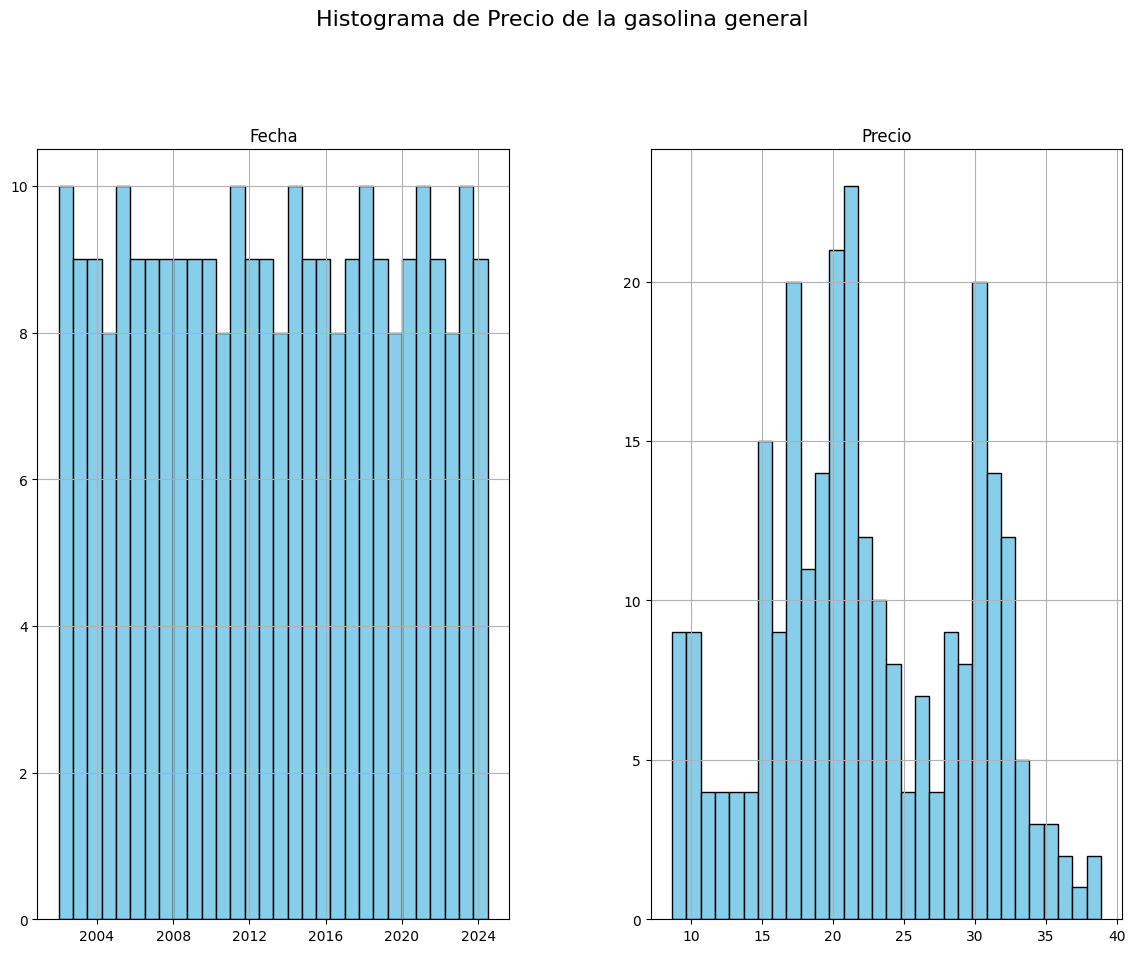

In [28]:
df_precios_melted.hist(figsize=(14, 10), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Histograma de Precio de la gasolina general', y=1.02, fontsize=16)
plt.show()

In [29]:
df_precios_melted.head()

,Fecha,Precio
0,2002-01-01,8.95
1,2002-02-01,8.66
2,2002-03-01,8.69
3,2002-04-01,9.38
4,2002-05-01,9.44


In [30]:
df_precios_melted.set_index('Fecha', inplace=True)

# Comprobar el índice
print(df_precios_melted.index)

DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01'],
              dtype='datetime64[ns]', name='Fecha', length=271, freq=None)


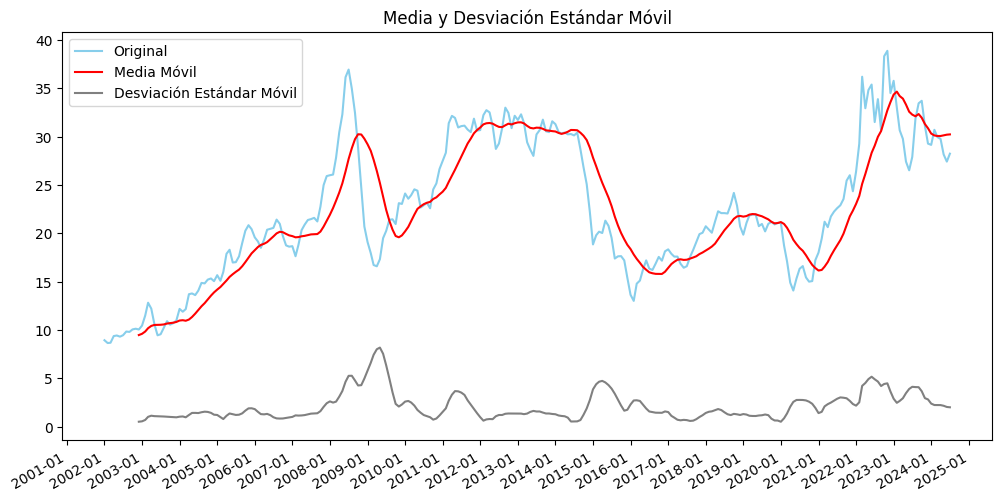

In [32]:
import matplotlib.dates as mdates
mediaMovil = df_precios_melted['Precio'].rolling(window=12).mean()
deMovil = df_precios_melted['Precio'].rolling(window=12).std()

# Configura el gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_precios_melted.index, df_precios_melted['Precio'], color="skyblue", label="Original")
plt.plot(df_precios_melted.index, mediaMovil, color='red', label='Media Móvil')
plt.plot(df_precios_melted.index, deMovil, color='grey', label='Desviación Estándar Móvil')

# Formatear el eje x para que muestre las fechas correctamente
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  # Rotar las fechas para mejor visibilidad

# Añadir leyenda y título
plt.legend(loc='best')
plt.title('Media y Desviación Estándar Móvil')
plt.show()

In [33]:
df_precios_melted['Precio'] = df_precios_melted['Precio'].interpolate()

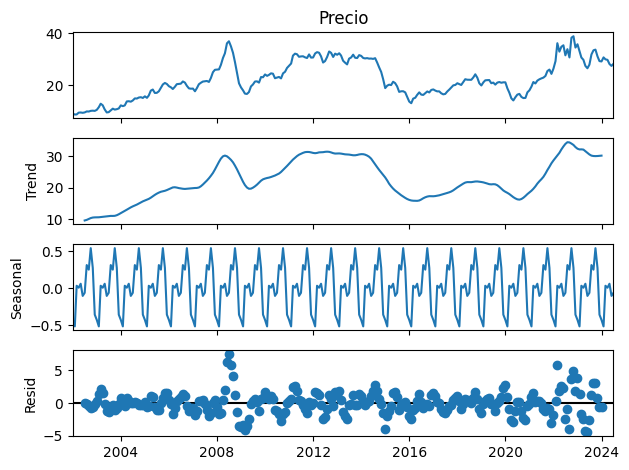

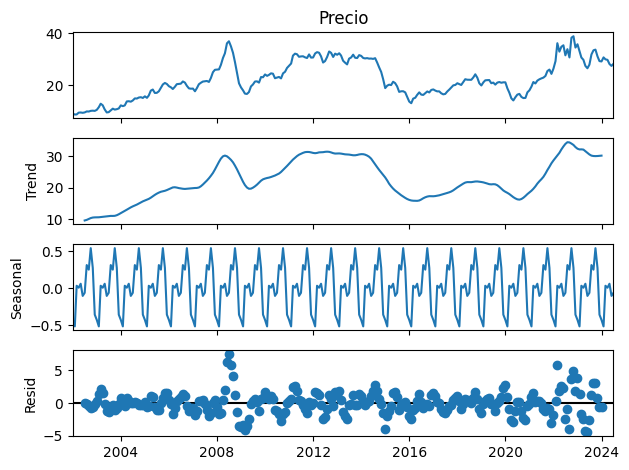

In [34]:
descomposicion = seasonal_decompose(df_precios_melted['Precio'], model='additive')
descomposicion.plot()

No se puede apreciar por completo, perohay una tendencia de crecimiento a entre 2010 y 2024

In [35]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df_precios_melted['Precio'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.511361
p-value                        0.112734
# de retardos usados           7.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


p-value es mayor a 0.05, no se puede rechazar la hipotesis nula de que existen raices unitarias.

La serie no es estacionaria en media

In [38]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie de Precios')
ts_precio_diff = df_precios_melted['Precio'].diff()
ts_precio_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_precio_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie de Precios
Estadístico de prueba       -5.837021e+00
p-value                      3.855189e-07
# de retardos usados         6.000000e+00
# de observaciones usadas    2.640000e+02
Critical Value (1%)         -3.455365e+00
Critical Value (5%)         -2.872551e+00
Critical Value (10%)        -2.572638e+00
dtype: float64


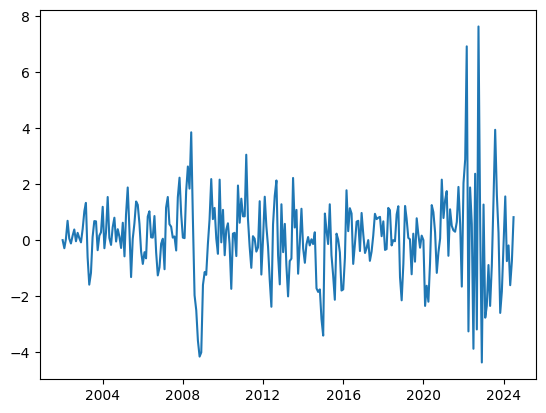

In [39]:
plt.plot(ts_precio_diff)

In [41]:
ts_precio_diff_df = ts_precio_diff.to_frame()

scaler = StandardScaler()
ts_precio_scaled = scaler.fit_transform(ts_precio_diff_df)

ts_precio_scaled[1:7]


array([[-0.24946402],
       [-0.02846576],
       [ 0.42734316],
       [-0.00774717],
       [-0.1320587 ],
       [ 0.05440859]])

In [46]:
entrenamiento = round(0.6*len(ts_precio_scaled))
val_prueba = round(0.2*len(ts_precio_scaled))
test = ts_precio_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_precio_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_precio_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

55

#### Serie supervisada

In [47]:
from operator import concat

def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [48]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

54

In [49]:
# Definir los parámetros
unidades = 1
paso = 3
caracteristicas = 1  # Es univariada

# Crear el modelo LSTM
modelo1 = Sequential()
modelo1.add(LSTM(units=unidades, input_shape=(paso, caracteristicas)))
modelo1.add(Dense(1))
modelo1.summary()

c:\Users\eunic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [51]:
lote = 1
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4688 - val_loss: 0.3754
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.4591 - val_loss: 0.3725
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.4510 - val_loss: 0.3696
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4428 - val_loss: 0.3666
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.4347 - val_loss: 0.3636
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.4269 - val_loss: 0.3608
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.4195 - val_loss: 0.3583
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.4127 - val_loss: 0.3560
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.4064 - val_loss: 0.3542
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.4007 - val_loss: 0.3527
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.3955 - val_loss: 0.3516
Epoch 12/50
163/163 ━━━━━━━━━━━━━━

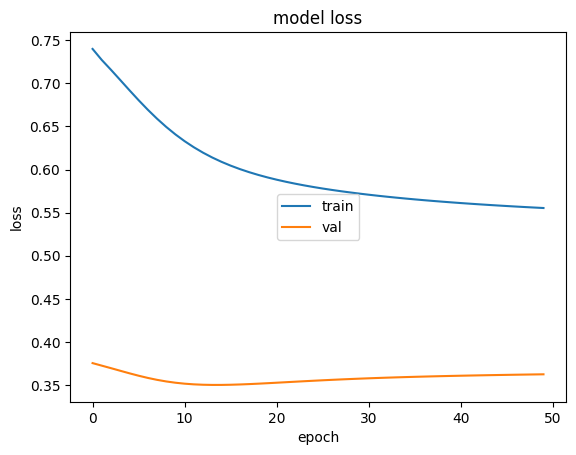

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [53]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.4367
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3378 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5638 


2.723797082901001

### Prediccion con modelo 1

In [57]:
prediccion_val = []


In [58]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion



In [59]:
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df_precios_melted.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df_precios_melted.values , n=entrenamiento+val_prueba)


In [62]:
df_val1 = pd.DataFrame(prediccion_val,index=df_precios_melted[(entrenamiento):entrenamiento+val_prueba].index)
df_test1 = pd.DataFrame(prediccion_test,index=df_precios_melted[entrenamiento+len(df_val1):len(df_precios_melted)].index)

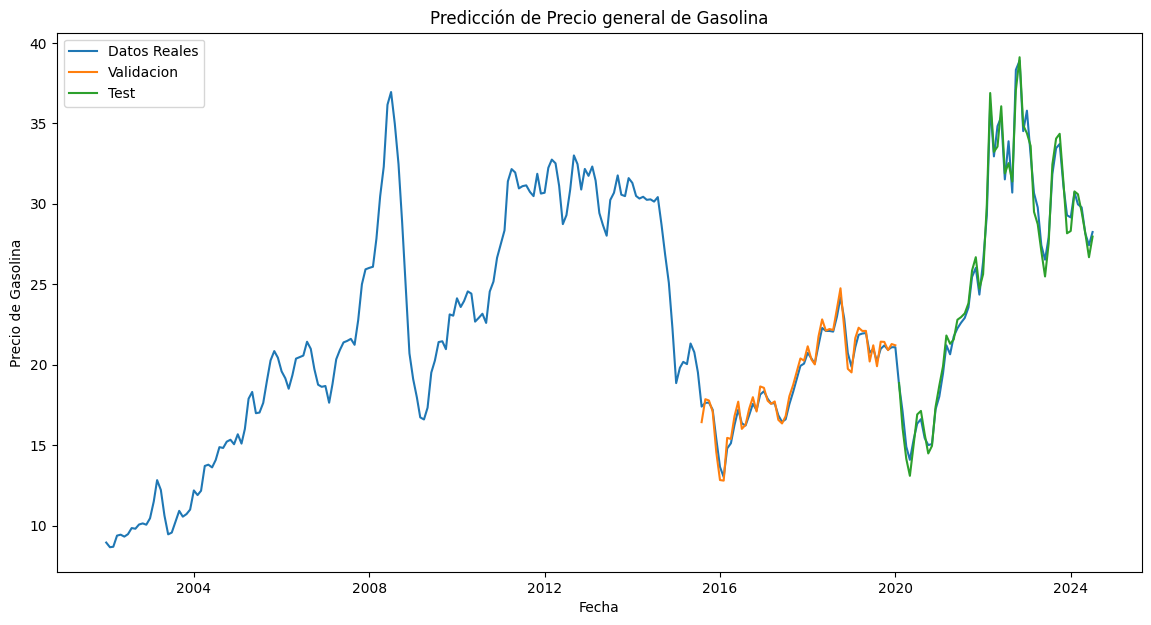

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(df_precios_melted , label='Datos Reales')
plt.plot(df_val1, label='Validacion')
plt.plot(df_test1, label='Test')

plt.title('Predicción de Precio general de Gasolina')
plt.xlabel('Fecha')
plt.ylabel('Precio de Gasolina')

plt.legend()

### Modelo 2

modelo 1 con diferentes valores y una capa mas


In [71]:
# Definir los parámetros
unidades = 50
paso = 3
caracteristicas = 1  # Es univariada

# Crear el modelo LSTM
modelo2 = Sequential() #           ↓ para la segunda capa
modelo2.add(LSTM(units=unidades, return_sequences=True, input_shape=(paso, caracteristicas)))
modelo2.add(LSTM(units= 25)) #segunda capa
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [73]:
# Ajustar parámetros
lote = 10
epocas = 100 

history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False, 
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4855 - val_loss: 0.3665
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4749 - val_loss: 0.3634
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4665 - val_loss: 0.3603
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4577 - val_loss: 0.3573
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4486 - val_loss: 0.3544
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4394 - val_loss: 0.3519
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4302 - val_loss: 0.3497
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4213 - val_loss: 0.3481
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4127 - val_loss: 0.3472
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4049 - val_loss: 0.3469
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3978 - val_loss: 0.3473
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

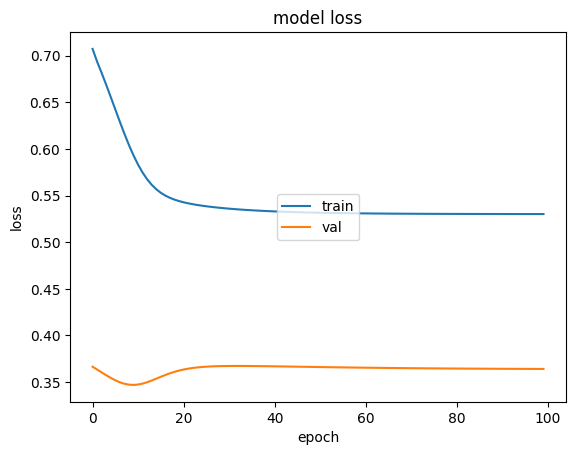

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [75]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.4104
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3399 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9246 


3.115412712097168

In [78]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = df_precios_melted.values , n=entrenamiento)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = df_precios_melted.values , n=entrenamiento+val_prueba)


In [79]:
df_val2 = pd.DataFrame(prediccion_val2,index=df_precios_melted[(entrenamiento):entrenamiento+val_prueba].index)
df_test2 = pd.DataFrame(prediccion_test2,index=df_precios_melted[entrenamiento+len(df_val1):len(df_precios_melted)].index)

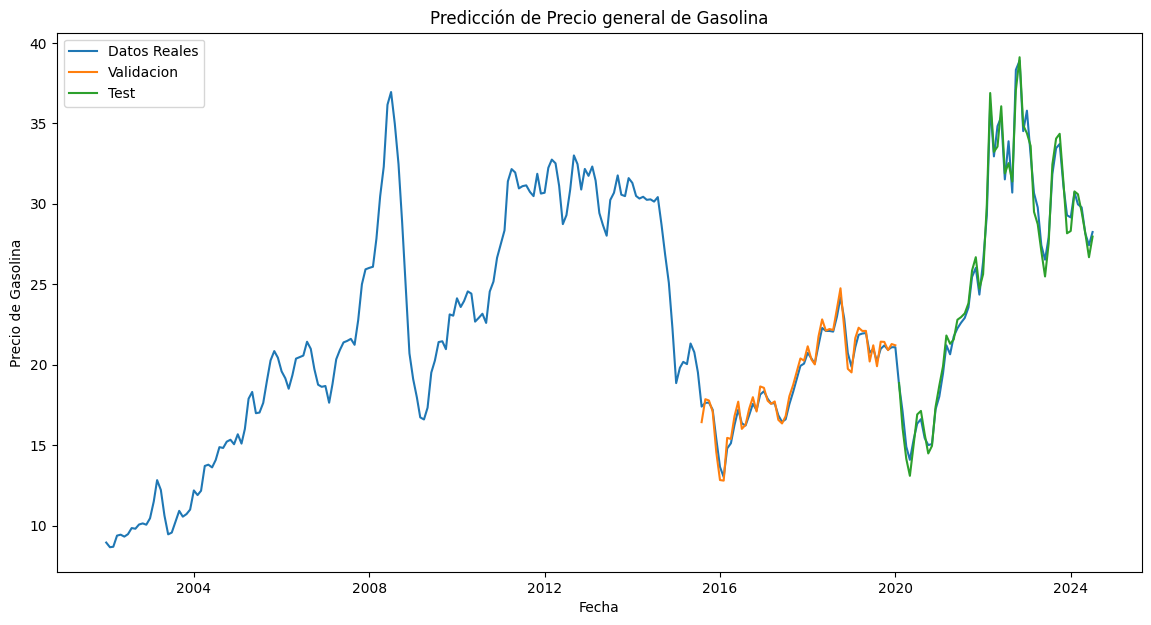

In [80]:
plt.figure(figsize=(14, 7))
plt.plot(df_precios_melted , label='Datos Reales')
plt.plot(df_val1, label='Validacion')
plt.plot(df_test1, label='Test')

plt.title('Predicción de Precio general de Gasolina')
plt.xlabel('Fecha')
plt.ylabel('Precio de Gasolina')

plt.legend()